In [1]:
import pandas as pd 
import numpy as np  
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

In [2]:
df =pd.read_csv("Datos_limpio.csv")#cargamos los datos limpios
df.head()

,Age,Height_cm,Weight_kg,Position,Training_Hours_Per_Week,Matches_Played_Past_Season,Previous_Injury_Count,Knee_Strength_Score,Hamstring_Flexibility,Reaction_Time_ms,Balance_Test_Score,Sprint_Speed_10m_s,Agility_Score,Sleep_Hours_Per_Night,Stress_Level_Score,Nutrition_Quality_Score,Warmup_Routine_Adherence,Injury_Next_Season,BMI
0,22,173,64,Midfielder,11.575308,36,1,77.460279,79.115738,284.487853,91.212476,5.874630,77.599705,8.238293,46.616415,81.472206,1,False,21.383942
1,18,170,67,Midfielder,12.275869,37,2,72.634442,82.541688,250.579249,87.294078,5.796269,94.418987,8.983737,49.368037,81.056677,1,False,23.183391
2,22,186,75,Forward,12.254896,12,2,77.064490,75.943631,269.119918,83.440688,5.731209,70.179176,7.229193,43.132808,64.877457,0,True,21.678807
3,20,172,62,Defender,9.006678,11,1,82.810232,73.878324,226.376412,87.591894,6.220212,83.473824,7.681029,51.528529,89.824744,1,False,20.957274
4,18,172,94,Midfielder,12.683668,10,2,76.772859,76.653043,229.021042,83.125161,5.385958,87.037256,6.728091,52.379718,71.569197,0,True,31.773932


En este notebook responderemos la pregunta: Alguna posicion en especifico tiene a lesionarse mas?

In [4]:
X = df[["Position"]]
y = df["Injury_Next_Season"]
X = pd.get_dummies(X, drop_first=True)
#Escalamos datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
#Hcemos test al 30%
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
log_reg = LogisticRegression(max_iter=500)
log_reg.fit(X_train, y_train)

y_pred1 = log_reg.predict(X_test)
y_prob1 = log_reg.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred1))
print(roc_auc_score(y_test, y_prob1))

              precision    recall  f1-score   support

       False       0.51      0.53      0.52       123
        True       0.48      0.46      0.47       117

    accuracy                           0.50       240
   macro avg       0.49      0.49      0.49       240
weighted avg       0.50      0.50      0.50       240

0.48210687235077476


In [11]:
pos_cols = [c for c in X.columns if "Position" in c] #separamos por posicion

coef_positions_log = pd.DataFrame({
    "feature": pos_cols,
    "coef": log_reg.coef_[0][[X.columns.get_loc(c) for c in pos_cols]], #.get_loc nos da el indice de una columna
    "odds_ratio": np.exp(log_reg.coef_[0][[X.columns.get_loc(c) for c in pos_cols]])
}).sort_values("odds_ratio", ascending=False)

print("\nREGRESION LOGISTICA POR POSICION")
print(coef_positions_log)


REGRESION LOGISTICA POR POSICION
               feature      coef  odds_ratio
0     Position_Forward  0.076144    1.079118
1  Position_Goalkeeper -0.013069    0.987016
2  Position_Midfielder -0.054140    0.947299


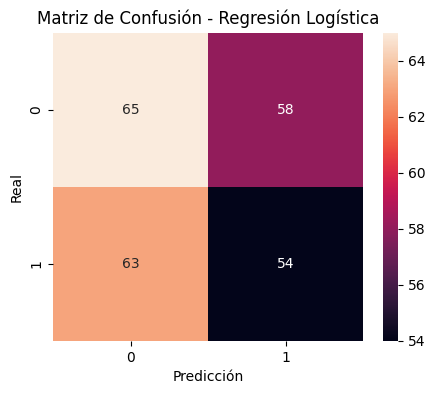

In [12]:
from sklearn.metrics import confusion_matrix
matriz_log = confusion_matrix(y_test, y_pred1)
plt.figure(figsize=(5,4))
sns.heatmap(matriz_log, annot=True, fmt='d')
plt.title("Matriz de Confusión - Regresión Logística")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

In [10]:
lasso = LogisticRegression(penalty="l1", solver="liblinear", max_iter=500)
lasso.fit(X_train, y_train) #usamos lasso con la penalizacion L1

y_pred2 = lasso.predict(X_test)
y_prob2 = lasso.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred2))
print(roc_auc_score(y_test, y_prob2))

lasso_coef = pd.DataFrame({"caracteristica": X.columns,"coef": lasso.coef_[0],
                           "odds_ratio": np.exp(lasso.coef_[0])}).sort_values("odds_ratio", ascending=False)

print("\n   COEFICIENTES LASSO POR POSICION   ")
print(lasso_coef[lasso_coef["caracteristica"].str.contains("Position", case=False)])

              precision    recall  f1-score   support

       False       0.52      0.80      0.63       123
        True       0.53      0.23      0.32       117

    accuracy                           0.53       240
   macro avg       0.53      0.52      0.48       240
weighted avg       0.53      0.53      0.48       240

0.48210687235077476

   COEFICIENTES LASSO POR POSICION   
        caracteristica      coef  odds_ratio
0     Position_Forward  0.077101    1.080151
1  Position_Goalkeeper -0.002025    0.997977
2  Position_Midfielder -0.043383    0.957545


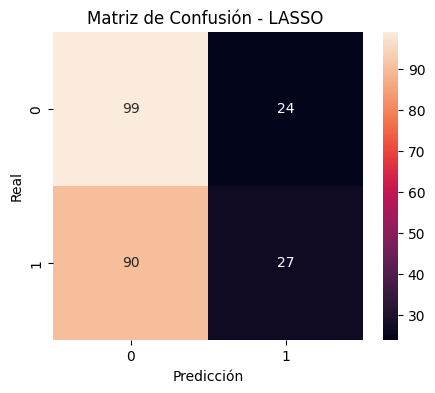

In [13]:
matriz_lasso = confusion_matrix(y_test, y_pred2)

plt.figure(figsize=(5,4))
sns.heatmap(matriz_lasso, annot=True, fmt='d')
plt.title("Matriz de Confusión - LASSO ")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

Tal como podemos ver las matrices de confusion tanto de regresion lasso como de regresion logistica,
quedaron muy "malos" esto se debe a que el modelo no es capaz de predecir correctamente si alguien se lesionara o no basandose 
en la posicion. En los graficos de barra que se aprecian abajo se observa que la diferencia en lesiones es muy baja dependiendo
de la posicion por lo que no podriamos concluir que una posicion afecte en la lesion.
Aun asi para asegurarnos haremos uso de knn y arbol de desicion.

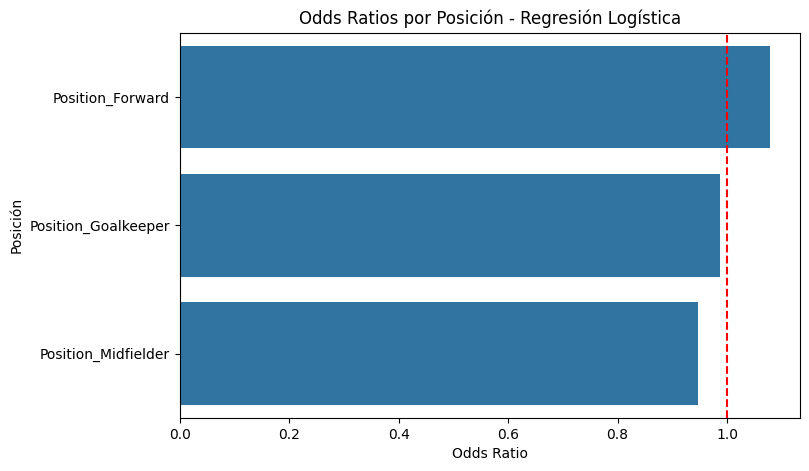

In [14]:
plt.figure(figsize=(8,5))
sns.barplot(data=coef_positions_log, x="odds_ratio", y="feature")
plt.axvline(1, color="red", linestyle="--")
plt.title("Odds Ratios por Posición - Regresión Logística")
plt.xlabel("Odds Ratio")
plt.ylabel("Posición")
plt.show()

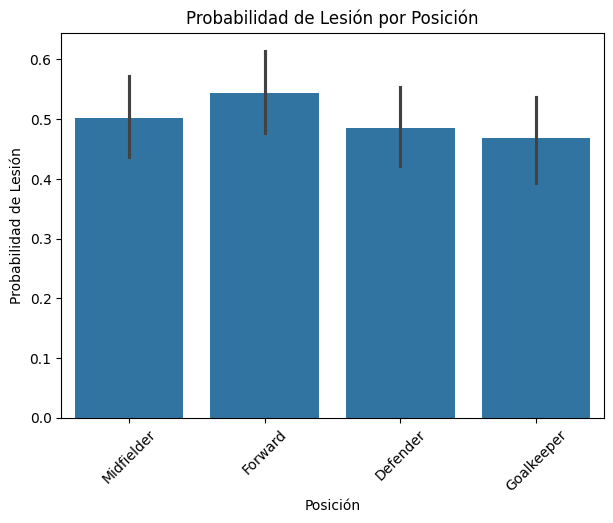

In [17]:
plt.figure(figsize=(7,5))
sns.barplot(x=df["Position"], y=df["Injury_Next_Season"], estimator=np.mean)
plt.title("Probabilidad de Lesión por Posición")
plt.xlabel("Posición")
plt.ylabel("Probabilidad de Lesión")
plt.xticks(rotation=45)
plt.show()

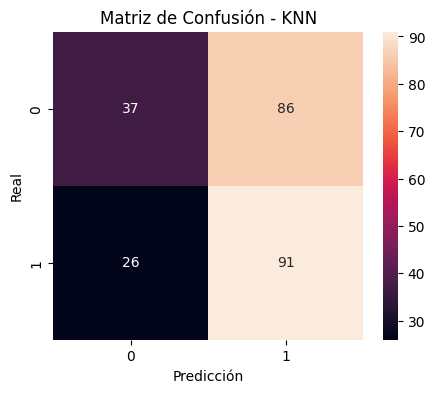


=== Reporte KNN ===
              precision    recall  f1-score   support

       False       0.59      0.30      0.40       123
        True       0.51      0.78      0.62       117

    accuracy                           0.53       240
   macro avg       0.55      0.54      0.51       240
weighted avg       0.55      0.53      0.51       240



In [19]:
from sklearn.neighbors import KNeighborsClassifier
#Primero usaremos KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

y_pred_knn = knn.predict(X_test)

cm_knn = confusion_matrix(y_test, y_pred_knn)

plt.figure(figsize=(5,4))
sns.heatmap(cm_knn, annot=True, fmt='d')
plt.title("Matriz de Confusión - KNN")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

print("\n=== Reporte KNN ===")
print(classification_report(y_test, y_pred_knn))

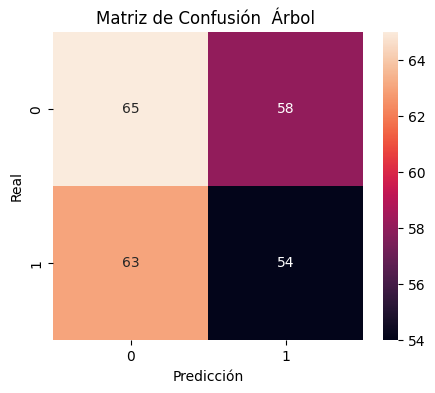


 Arbol 
              precision    recall  f1-score   support

       False       0.51      0.53      0.52       123
        True       0.48      0.46      0.47       117

    accuracy                           0.50       240
   macro avg       0.49      0.49      0.49       240
weighted avg       0.50      0.50      0.50       240



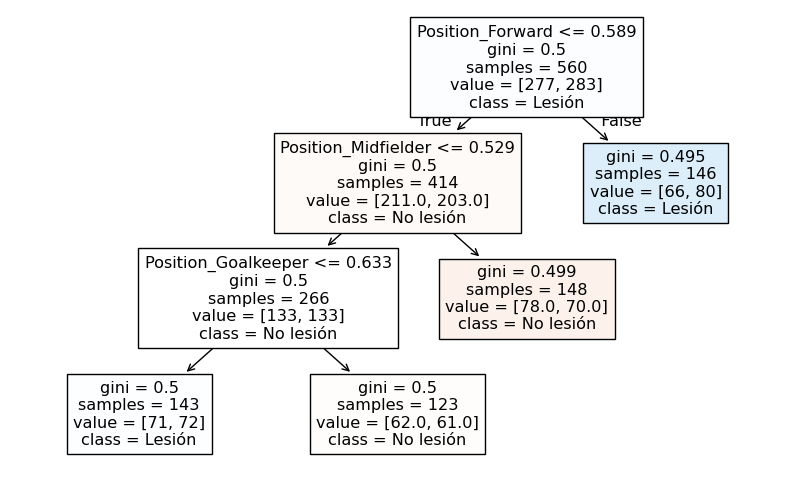

In [22]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

# Ahora probaremos con el arbol
tree = DecisionTreeClassifier( max_depth=3, random_state=30) #usamos depth 3 para evitar overfitting

tree.fit(X_train, y_train)

y_pred_tree = tree.predict(X_test)


cm_tree = confusion_matrix(y_test, y_pred_tree)

plt.figure(figsize=(5,4))
sns.heatmap(cm_tree, annot=True, fmt='d')
plt.title("Matriz de Confusión  Árbol ")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

print("\n Arbol ")
print(classification_report(y_test, y_pred_tree))

plt.figure(figsize=(10,6))
plot_tree(tree, feature_names=X.columns, class_names=["No lesión", "Lesión"], filled=True)
plt.show()

In [ ]:
Tal como podemos observar ni usar knn ni usar el arbol de desiciones cambia drasticamente el resultado de nuestra prediccion
vista en la matriz de confusion, por lo que, podemos concluir que la posicion en la que juega alguien no es relevante para saber si llegara a 
lesionarse o no en un futuro
